In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import gc
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import clear_output


### Config

In [2]:
cuda_available = torch.cuda.is_available()

print(f"CUDA disponible : {cuda_available}")

# Affiche également le nombre de GPU disponibles et leur nom si CUDA est disponible
if cuda_available:
    print(f"Nombre de GPU disponibles : {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("Aucun GPU n'est disponible. Entraînement sur CPU.")

CUDA disponible : True
Nombre de GPU disponibles : 1
GPU 0: NVIDIA GeForce GTX 1660 Ti


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Utils

In [4]:
def add_noise_to_labels(y, noise_level=0.1, num_classes=10):
    """
    Adds noise to the labels in the dataset.

    Parameters:
    dataset (torch.utils.data.Dataset): The dataset to add noise to.
    noise_level (float): The fraction of labels to add noise to (between 0 and 1).
    num_classes (int): The number of classes in the dataset.

    Returns:
    torch.utils.data.Dataset: The dataset with noisy labels.
    """
    noisy_y = []
    for label in y:
        if random.random() < noise_level:
            # Randomly change the label to a different class
            new_label = random.randint(0, num_classes - 1)
            # Ensure new label is different from the original
            while new_label == label:
                new_label = random.randint(0, num_classes - 1)
            noisy_y.append(new_label)
        else:
            noisy_y.append(label)
    
    return noisy_y

In [5]:
def preprocess_MNIST(n_train=4000, noise_level=0.2, zero_vs_all=False, downsample_size=None):
    transform = None
    if downsample_size is not None:
        transform = transforms.Compose([
            transforms.Resize(downsample_size),
            transforms.ToTensor()
        ])

    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    X_train = []
    y_train = []
    for i in range(len(trainset)):
        image, label = trainset[i]
        X_train.append(np.array(image)/255)
        y_train.append(float(label==0) if zero_vs_all else float(label))

    X_train, _, y_train, _ = train_test_split(X_train, y_train, train_size=n_train, stratify=y_train, random_state=42)

    num_classes = 2 if zero_vs_all else 10
    noisy_y_train = add_noise_to_labels(y_train, noise_level=noise_level, num_classes=num_classes)

    X_train_tensor = torch.tensor(np.array(X_train), dtype=torch.float32).unsqueeze(1)  # Add channel dimension
    y_train_tensor = torch.tensor(noisy_y_train, dtype=torch.float32)

    train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True) 

    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    X_test = []
    y_test = []
    for i in range(len(testset)):
        image, label = testset[i]
        X_test.append(np.array(image)/255)
        y_test.append(float(label==0) if zero_vs_all else float(label))

    X_test_tensor = torch.tensor(np.array(X_test), dtype=torch.float32).unsqueeze(1)  # Add channel dimension
    y_test_tensor = torch.tensor(np.array(y_test), dtype=torch.float32)

    test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=True) 

    return train_loader, test_loader

### Data

In [6]:
train_loader, test_loader = preprocess_MNIST(n_train=3000, noise_level=0.2, zero_vs_all=False, downsample_size=(14, 14))

### Model

In [7]:
class Net(nn.Module):
    def __init__(self, width=512, input_size=28*28):
        super(Net, self).__init__()
        self.input_size = input_size
        self.fc1 = nn.Linear(input_size, width)  # First layer (784 inputs, width outputs)
        self.fc2 = nn.Linear(width, 1, bias=False)  # Second layer (width inputs, 1 output)

        self.init_weights()

    def forward(self, x):
        x = x.view(-1, self.input_size)  # Flatten the image
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def init_weights(self):
        # Initialize weights with small random values
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight, gain=1.0)
                if m.bias is not None:
                    m.bias.data.fill_(0.01)


In [8]:
def train(model, train_loader, test_loader, epochs=2000, lr=0.01, momentum=0.95):
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    for epoch in range(epochs):
        clear_output(wait=True)
        model.train()
        running_loss = sum(
            train_step(data, model, criterion, optimizer)
            for data in train_loader
        ) / len(train_loader)
        print(f'Epoch {epoch + 1}/{epochs} - Loss: {running_loss:.3f}')

        test_loss = evaluate(model, test_loader, criterion)
        print(f'Test Loss: {test_loss:.3f}')

    print('Finished Training')
    return test_loss

def train_step(data, model, criterion, optimizer):
    inputs, labels = (d.cuda() if torch.cuda.is_available() else d for d in data)
    optimizer.zero_grad()
    outputs = model(inputs).flatten()
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    return loss.item()

def evaluate(model, test_loader, criterion):
    model.eval()
    with torch.no_grad():
        losses = [
            criterion(model(inputs.cuda() if torch.cuda.is_available() else inputs).flatten(), 
                      labels.cuda() if torch.cuda.is_available() else labels).item()
            for inputs, labels in test_loader
        ]
    return sum(losses) / len(test_loader)

### Double descent experiments

In [ ]:
x_width = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38,
            40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
            60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150]

x_loss = []
x_complexity = np.zeros(len(x_width))
train_loader, test_loader = preprocess_MNIST(n_train=4000, noise_level=0.2, zero_vs_all=False)

for i, width in enumerate(x_width):
    net = Net(width=width).cuda()
    print("Width :", width)
    trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {trainable_params}")
    
    x_loss.append(train(net, train_loader, test_loader))
    complexity = 0
    k = 0
    for data in test_loader:
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda().float()
        for input in inputs:
            complexity += compute_complexity(net, input)
            k += 1
            
        if k > 1000:
            break

            
    x_complexity[i] += complexity / k
    np.save("x_loss_0.2.npy", np.array(x_loss))
    np.save("x_complexity_0.2.npy", np.array(x_complexity))

x_loss = []
x_complexity = np.zeros(len(x_width))
train_loader, test_loader = preprocess_MNIST(n_train=4000, noise_level=0, zero_vs_all=False)

for i, width in enumerate(x_width):
    net = Net(width=width).cuda()
    print("Width :", width)
    trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {trainable_params}")
    
    x_loss.append(train(net, train_loader, test_loader))
    complexity = 0
    k = 0
    for data in test_loader:
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda().float()
        for input in inputs:
            complexity += compute_complexity(net, input)
            k += 1
            
        if k > 1000:
            break

            
    x_complexity[i] += complexity / k
    np.save("x_loss_0.npy", np.array(x_loss))
    np.save("x_complexity_0.npy", np.array(x_complexity))

x_loss = []
x_complexity = np.zeros(len(x_width))
train_loader, test_loader = preprocess_MNIST(n_train=4000, noise_level=0.1, zero_vs_all=False)

for i, width in enumerate(x_width):
    net = Net(width=width).cuda()
    print("Width :", width)
    trainable_params = sum(p.numel() for p in net.parameters() if p.requires_grad)
    print(f"Number of trainable parameters: {trainable_params}")
    
    x_loss.append(train(net, train_loader, test_loader))
    complexity = 0
    k = 0
    for data in test_loader:
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda().float()
        for input in inputs:
            complexity += compute_complexity(net, input)
            k += 1
            
        if k > 1000:
            break

            
    x_complexity[i] += complexity / k
    np.save("x_loss_0.1.npy", np.array(x_loss))
    np.save("x_complexity_0.1.npy", np.array(x_complexity))
    

In [71]:
np.load("x_complexity.npy")

array([15.61506403, 15.37969924, 15.52957402,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ])

In [54]:
for data in test_loader:
    images, labels = data
    if torch.cuda.is_available():
        images, labels = images.cuda(), labels.cuda().float()
    break

In [58]:
net(images)

tensor([[ 0.2992],
        [ 0.2161],
        [-0.0052],
        [ 0.0676],
        [ 0.2071],
        [-0.1314],
        [ 0.1299],
        [ 0.1844],
        [-0.0635],
        [ 0.2571],
        [ 0.1550],
        [ 0.4407],
        [ 0.1320],
        [ 0.3603],
        [ 0.1568],
        [-0.1318],
        [ 0.1648],
        [ 0.9928],
        [ 0.2608],
        [-0.0331],
        [ 0.0911],
        [ 0.1491],
        [ 0.0940],
        [ 0.1026],
        [-0.0319],
        [-0.1611],
        [ 0.1286],
        [ 0.1215],
        [-0.0474],
        [-0.0760],
        [ 0.2635],
        [ 0.0015],
        [-0.0629],
        [ 0.9973],
        [ 0.1705],
        [ 0.4604],
        [ 0.4908],
        [ 0.0334],
        [ 0.1841],
        [ 0.3704],
        [ 0.1272],
        [ 0.1643],
        [-0.2608],
        [ 0.3427],
        [ 0.2073],
        [ 0.8527],
        [ 0.4646],
        [-0.0040],
        [ 0.1377],
        [-0.5717],
        [ 0.2506],
        [-0.1736],
        [ 0.

### Min-norm solution in deep model experiments

In [29]:
# Step 1: Extract Features from the First Layer
net.eval()
with torch.no_grad():  # Disable gradient calculation
    features = []
    targets = []
    
    for inputs, labels in train_loader:  # Iterate over each batch
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda().float()  # Move to GPU if available
        
        # Flatten each image in the batch and process through the first layer
        for input in inputs:
            input_flat = input.flatten()
            layer_output = net.fc1(input_flat).tolist()
            features.append(layer_output)
        
        # Append labels to the targets list
        targets.extend(labels.cpu().numpy().tolist())
        
# Step 2: Get Weights of the Second Layer
weights_layer2 = net.fc2.weight.data
# Step 3: Calculate Min-Norm Solution for Linear Regression
A_pinv = torch.pinverse(torch.tensor(features))
min_norm_solution = torch.mm(A_pinv, torch.tensor(targets).unsqueeze(1)).to(device=device)

# Step 4: Compare the Weights
distance = torch.norm(min_norm_solution - weights_layer2)
print(f"Distance between the weights: {distance.item()}")

Distance between the weights: 96.60978698730469


In [32]:
min_norm_solution

tensor([[-1.2731],
        [ 0.4054],
        [ 0.5735],
        [ 0.4782],
        [-0.8760],
        [-0.1699],
        [-0.1226],
        [-0.6283],
        [ 0.1956],
        [-0.6912],
        [-0.1450],
        [-0.3236],
        [ 0.3047],
        [-0.0459],
        [-0.0077],
        [-0.5580],
        [-0.7581],
        [ 0.2933],
        [-0.0979],
        [-0.0610],
        [ 0.2158],
        [ 0.7458],
        [ 0.0440],
        [ 0.5599],
        [ 0.1038],
        [ 0.5242],
        [ 0.3997],
        [-0.1202],
        [-0.2732],
        [ 0.1547],
        [ 0.0920],
        [-0.5275],
        [ 0.4231],
        [ 0.1037],
        [-0.4678],
        [ 0.1040],
        [-0.0530],
        [ 0.0093],
        [ 0.2303],
        [-0.0906],
        [ 0.1852],
        [-0.0880],
        [-0.1947],
        [-0.0651],
        [ 0.3008],
        [ 0.3229],
        [-0.2539],
        [ 0.7687],
        [ 0.5667],
        [ 0.2789],
        [ 0.1274],
        [ 0.1214],
        [ 0.

In [31]:
torch.norm(min_norm_solution)

tensor(5.8142, device='cuda:0')

In [33]:
weights_layer2.size()

torch.Size([1, 200])

### NTK experiments

In [10]:
for data in test_loader:
    inputs, labels = data
    if torch.cuda.is_available():
        inputs, labels = inputs.cuda(), labels.cuda().float()
    break
y = inputs[0].clone().detach().requires_grad_(True)

In [11]:
def compute_complexity(net, y):
    net.eval()  # Evaluation mode
    # Compute gradient at y
    output_y = net(y)
    grad_y = torch.autograd.grad(outputs=output_y, 
                                 inputs=net.parameters(),
                                 grad_outputs=torch.ones_like(output_y),
                                 retain_graph=True, 
                                 create_graph=True)
    
    # Function to compute the dot product of gradients
    def compute_ntk_dot_product(grad_x, grad_y):
        dot_product = sum(torch.sum(gx * gy) for gx, gy in zip(grad_x, grad_y))
        return dot_product.item()
    
    # Compute NTK for each x in the training set
    ntk_values = []
    for batch in train_loader:
        x, _ = batch  # Assuming you have (input, label) pairs in train_loader
        if torch.cuda.is_available():
            x = x.cuda() # Move to GPU if available
        x.requires_grad = True
    
        # Compute gradient at x
        output_x = net(x)
        grad_x = torch.autograd.grad(outputs=output_x, 
                                     inputs=net.parameters(), 
                                     grad_outputs=torch.ones_like(output_x),
                                     retain_graph=True, 
                                     create_graph=True)
    
        # Compute NTK value for (x, y) and store it
        ntk_value = compute_ntk_dot_product(grad_x, grad_y)
        ntk_values.append(ntk_value)

    return sum(np.array(ntk_values)**2)

In [12]:
def compute_ntk_matrix(net, train_loader):
    net.eval()  # Evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    # Precompute and store gradients for each x in the training set
    gradients = []
    for batch in train_loader:
        x, _ = batch
        x = x.to(device).requires_grad_(True)

        output_x = net(x)
        grad_x = torch.autograd.grad(outputs=output_x, 
                                     inputs=net.parameters(), 
                                     grad_outputs=torch.ones_like(output_x),
                                     retain_graph=True, 
                                     create_graph=True)
        gradients.append(grad_x)

    # Initialize NTK matrix
    num_samples = len(train_loader.dataset)
    ntk_matrix = np.zeros((num_samples, num_samples))

    # Compute NTK values
    for i, grad_x in enumerate(gradients):
        for j, grad_y in enumerate(gradients[i:], start=i):
            dot_product = sum(torch.sum(gx * gy) for gx, gy in zip(grad_x, grad_y)).item()
            ntk_matrix[i, j] = dot_product
            ntk_matrix[j, i] = dot_product  # Use symmetry

    return ntk_matrix

In [13]:
def compute_feature_matrix(net, train_loader, y):
    net.eval()  # Evaluation mode
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    net.to(device)

    gradients = []
    for batch in train_loader:
        x, _ = batch
        for single_x in x:  # Iterate over each example in the batch
            single_x = single_x.unsqueeze(0).to(device).requires_grad_(True)
            
            output_x = net(single_x)
            grad_x = torch.autograd.grad(outputs=output_x, 
                                         inputs=net.parameters(), 
                                         grad_outputs=torch.ones_like(output_x),
                                         retain_graph=True, 
                                         create_graph=True)
            # Flatten and concatenate gradients for each parameter
            grad_x_vector = torch.cat([g.contiguous().view(-1) for g in grad_x])
            gradients.append(grad_x_vector)

    # Process y in the same way
    y = y.to(device).requires_grad_(True)
    output_y = net(y)
    grad_y = torch.autograd.grad(outputs=output_y, 
                                 inputs=net.parameters(), 
                                 grad_outputs=torch.ones_like(output_y),
                                 retain_graph=True, 
                                 create_graph=True)
    grad_y_vector = torch.cat([g.contiguous().view(-1) for g in grad_y])

    # Stack all gradients to form the feature matrices
    phi = torch.stack(gradients)
    return phi, grad_y_vector

In [14]:
def compute_matrix(phi, p):
    phi_t = phi.T
    if p > 4000:
        phi_phi_t_inv = torch.inverse(torch.mm(phi, phi_t))
        del phi
        gc.collect()
        result = torch.mm(phi_t, phi_phi_t_inv)
    else:
        phi_t_phi_inv = torch.inverse(torch.mm(phi_t, phi))
        del phi
        gc.collect()
        result = torch.mm(phi_phi_t_inv, phi_t)
    return result

def compute_matrix_pseudo_inverse(phi, p):
    phi_phi_t_pinv = torch.pinverse(phi)
    del phi
    gc.collect()
    return phi_phi_t_pinv

In [30]:
torch.mm(phi.T, phi)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  7.6948,  2.4910,  2.7091],
        [ 0.0000,  0.0000,  0.0000,  ...,  2.4910, 37.4685,  8.4904],
        [ 0.0000,  0.0000,  0.0000,  ...,  2.7091,  8.4904, 24.5122]],
       device='cuda:0', grad_fn=<MmBackward0>)

In [26]:
net = Net(width=6).cuda()
p = sum(parameter.numel() for parameter in net.parameters() if parameter.requires_grad)

In [27]:
p

4770

In [45]:
list(phi[-1])

[tensor(-0., device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(-0., device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(-0., device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(-0., device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(-0., device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(-0., device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(-0., device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(-0., device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(-0., device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(-0., device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(-0., device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(-0., device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(-0., device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(-0., device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(-0., device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(-0., device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(-0., device='cuda:0', grad_fn=<UnbindBackward0>),
 tensor(-0., d

In [21]:
x_width = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 24, 26, 28, 30, 35, 40, 50, 54, 56, 58, 60, 62, 64, 68]


In [15]:
x_width = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 24, 26, 28, 30, 35, 40, 50, 54, 56, 58, 60, 62, 64, 68]


x_complexity = np.zeros(len(x_width))

for i in range(10):
    for i, width in enumerate(x_width):
        print(width)
        net = Net(width=width, input_size=14*14).cuda()
        p = sum(parameter.numel() for parameter in net.parameters() if parameter.requires_grad)
        print(p)
        phi, phi_y = compute_feature_matrix(net, train_loader, y)
        net = None
        inverse = compute_matrix_pseudo_inverse(phi, p)
        s = torch.mm(phi_y.unsqueeze(-1).T, inverse)
        res = 0
        for s_i in s[0]:
            res += s_i**2
        phi = None
        phi_y = None
        inverse = None
        s = None
        torch.cuda.empty_cache()
        gc.collect()
        x_complexity[i] += float(res.cpu())

x_complexity /= 10

54
10692
56
11088
58
11484
60
11880
62
12276
64
12672
68
13464
54
10692
56
11088
58
11484
60
11880
62
12276
64
12672
68
13464
54
10692
56
11088
58
11484
60
11880
62
12276
64
12672
68
13464
54
10692
56
11088
58
11484
60
11880
62
12276
64
12672
68
13464
54
10692
56
11088
58
11484
60
11880
62
12276
64
12672
68
13464
54
10692
56
11088
58
11484
60
11880
62
12276
64
12672
68
13464
54
10692
56
11088
58
11484
60
11880
62
12276
64
12672
68
13464
54
10692
56
11088
58
11484
60
11880
62
12276
64
12672
68
13464
54
10692
56
11088
58
11484
60
11880
62
12276
64
12672
68
13464
54
10692
56
11088
58
11484
60
11880
62
12276
64
12672
68
13464


In [17]:
x_complexity_2 = np.load("x_complexity.npy")

In [18]:
x_complexity_3 = np.concatenate((x_complexity_2, x_complexity))

In [52]:
x_complexity = np.array(x_complexity)

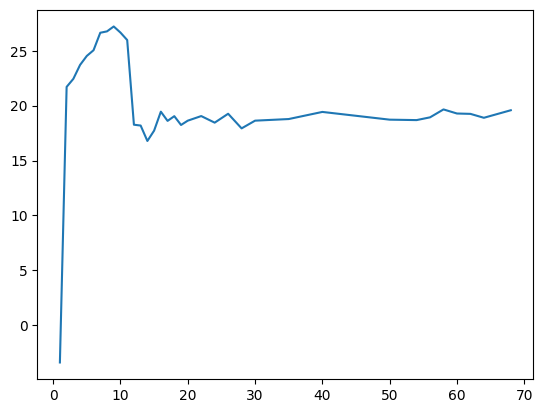

In [23]:
plt.plot(x_width[:len(x_complexity_3)], np.log(x_complexity_3[:]))

In [72]:
inverse = compute_matrix(phi)

In [77]:
phi_y.unsqueeze(-1)

tensor([[-0.],
        [-0.],
        [-0.],
        ...,
        [0.],
        [0.],
        [0.]], device='cuda:0', grad_fn=<UnsqueezeBackward0>)

In [95]:
res

tensor([[-0.0092, -0.0125,  0.0064,  ...,  0.0034,  0.0158, -0.0062]],
       device='cuda:0', grad_fn=<MmBackward0>)

In [79]:
res = torch.mm(phi_y.unsqueeze(-1).T, inverse)

In [74]:
len(inverse[0])

4000

In [36]:
len(train_loader)

32

In [70]:
len(phi)

4000

In [81]:
x_width = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38,
            40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
            60, 65, 70, 75, 80,]# 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150, 155,
            #160, 165, 170, 175, 180, 185, 190, 200, 210, 220, 230, 240, 250, 260, 270, 280, 290, 300, 350,
            #400, 450, 500, 550, 600, 650, 700, 750, 800]

x_complexity = np.zeros(len(x_width))
for i in range(1):
    print(i)
    for j in range(len(x_width)):
        net = Net(width=x_width[j]).cuda()
        train(net, train_loader, test_loader, epochs=10)
        print("Width :", x_width[j])
        complexity = 0
        k = 0
        for data in test_loader:
            inputs, labels = data
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda().float()
            for input in inputs:
                complexity += compute_complexity(net, input)
                k += 1
                if k > 20:
                    break
            break

            
        x_complexity[j] += complexity / k

x_complexity = x_complexity / 1

Epoch 10/10 - Loss: 0.164
Test Loss: 0.058
Finished Training
Width : 80


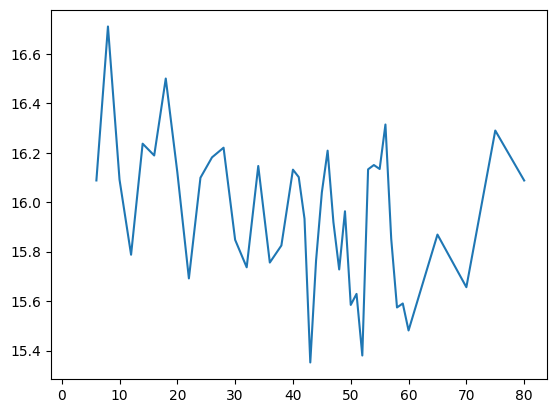

In [82]:
plt.plot(x_width, x_complexity)